We recommend using a new virtual environment

In [1]:
pip install netCDF4 dask superposed-pulses blobmodel fppanalysis closedexpressions

  Using cached superposed_pulses-1.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


Let's create a synthetic time series

100%|███████████████████████████████████████████████████████████| 499/499 [00:00<00:00, 6908.18it/s]


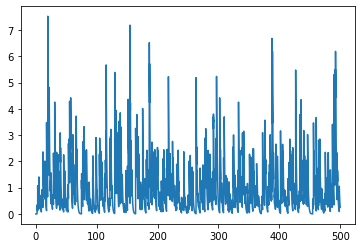

In [1]:
import matplotlib.pyplot as plt
import model.point_model as pm

model = pm.PointModel(gamma=1, total_duration=500, dt=0.01)
times, signal = model.make_realization()

plt.plot(times, signal)
plt.show()


We can extend the model by adding a radial coordinate:

In [6]:
from blobmodel import Model, show_model

bm = Model(Nx=200, Ny=1, Lx=10, Ly=0, dt=0.1, T=20, blob_shape='exp',num_blobs=100)

ds = bm.make_realization(file_name="example.nc")

Summing up Blobs: 100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 526.53it/s]


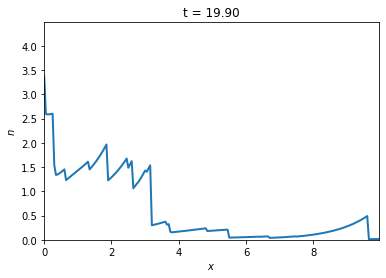

In [7]:
show_model(ds, save=True, gif_name = 'evolving_profile.gif')

In [6]:
# from IPython.display import Image
# Image(filename="evolving_profile.gif")

Summing up Blobs: 100%|█████████████████████████████████████| 10000/10000 [00:01<00:00, 5410.92it/s]


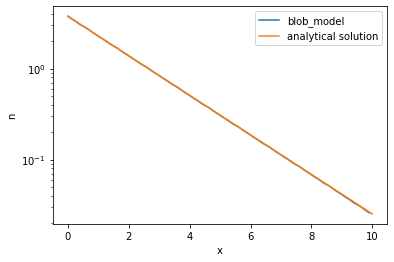

In [4]:
from blobmodel import Model, DefaultBlobFactory
import numpy as np

# use DefaultBlobFactory to define distribution functions fo random variables
bf = DefaultBlobFactory(A_dist="deg", W_dist="deg", vx_dist="deg", vy_dist="zeros")

tmp = Model(
    Nx=100,
    Ny=1,
    Lx=10,
    Ly=0,
    dt=1,
    T=1000,
    blob_shape="exp",
    t_drain=2,
    periodic_y=False,
    num_blobs=10000,
    blob_factory=bf,
)

ds = tmp.make_realization(file_name="profile_comparison.nc", speed_up=True, error=1e-2)


def plot_convergence_to_analytical_solution(ds):

    x = np.linspace(0, 10, 100)
    t_p = 1
    t_w = 1 / 10
    amp = 1
    v_p = 1.0
    t_loss = 2.0
    t_d = t_loss * t_p / (t_loss + t_p)

    analytical_profile = (
        1 / np.sqrt(np.pi) * t_d / t_w * amp * np.exp(-x / (v_p * t_loss))
    )

    ds.n.isel(y=0).mean(dim=("t")).plot(label="blob_model")
    plt.yscale("log")
    plt.plot(x, analytical_profile, label="analytical solution")
    plt.legend()
    plt.show()


plot_convergence_to_analytical_solution(ds)

Summing up Blobs:   0%|                                                     | 0/100 [00:00<?, ?it/s]/home/gregor/git/2d_propagating_blobs/blobmodel/blobs.py:60: UserWarning: blob width big compared to Ly
  warnings.warn("blob width big compared to Ly")
Summing up Blobs: 100%|███████████████████████████████████████████| 100/100 [00:29<00:00,  3.38it/s]


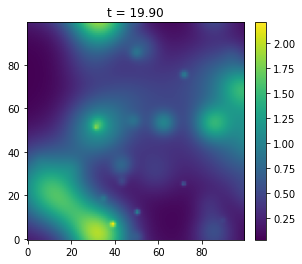

In [8]:
from blobmodel import Model, show_model

# here you can define your custom parameter distributions

bm = Model(
    Nx=100,
    Ny=100,
    Lx=10,
    Ly=10,
    dt=0.1,
    T=20,
    periodic_y=True,
    blob_shape="gauss",
    num_blobs=100,
    t_drain=1e10,
)

# create data
ds = bm.make_realization(speed_up=True, error=1e-2)
# show animation and save as gif
show_model(dataset=ds, interval=100, save=True, gif_name="2d_blobs.gif", fps=10)

In [11]:
# from IPython.display import Image
# Image(filename="2d_blobs.gif")